<p>The Kullback-Leibler (KL) divergence between distributions $p$ and $q$ is
defined as</p>

<p>$$
\mathcal{D}_{\mathrm{KL}}[p(x) || q(x)] :=
\mathbb{E}_{p(x)} \left [ \log \left ( \frac{p(x)}{q(x)} \right ) \right ].
$$</p>

<p>It can be expressed more succinctly as</p>

<p>$$
\mathcal{D}_{\mathrm{KL}}[p(x) || q(x)] = \mathbb{E}_{p(x)} [ \log r^{*}(x) ],
$$</p>

<p>where $r^{*}(x)$ is defined to be the ratio of between the densities $p(x)$ and
$q(x)$,</p>

<p>$$
r^{*}(x) := \frac{p(x)}{q(x)}.
$$</p>

<p>This density ratio is crucial for computing not only the KL divergence but for
all $f$-divergences, defined as<sup class="footnote-ref" id="fnref:1"><a href="#fn:1">1</a></sup></p>

<p>$$
\mathcal{D}_f[p(x) || q(x)] :=
\mathbb{E}_{q(x)} \left [ f \left ( \frac{p(x)}{q(x)} \right ) \right ].
$$</p>

<p>Rarely can this expectation (i.e. integral) can be calculated analytically&mdash;in
most cases, we must resort to Monte Carlo approximation methods, which
explicitly requires the density ratio.
In the more severe case where this density ratio is unavailable, because either
or both $p(x)$ and $q(x)$ are not calculable, we must resort to methods for
<em>density ratio estimation</em>.
In this post, we illustrate how to perform density ratio estimation by
exploiting its tight correspondence to <em>probabilistic classification</em>.</p>

<h3 id="example-univariate-gaussians">Example: Univariate Gaussians</h3>

<p>Let us consider the following univariate Gaussian distributions as the running
example for this post,</p>

<p>$$
p(x) = \mathcal{N}(x \mid 1, 1^2),
\qquad
\text{and}
\qquad
q(x) = \mathcal{N}(x \mid 0, 2^2).
$$</p>

<p>We will be using <em>TensorFlow</em>, <em>TensorFlow Probability</em>, and <em>Keras</em> in the
code snippets throughout this post.</p>

In [20]:
import torch
import torch.distributions as dist
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

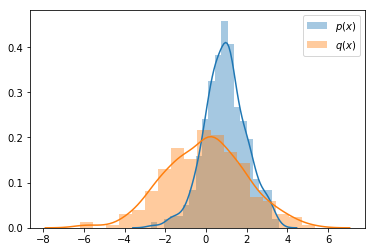

In [21]:
p = dist.Normal(loc=1.0, scale=1.0)
q = dist.Normal(loc=0.0, scale=2.0)

sns.distplot(p.sample((500,)).numpy(), label='$p(x)$')
sns.distplot(q.sample((500,)).numpy(), label='$q(x)$')
plt.legend()

<p>For any pair of distributions, we can implement their density ratio function $r$
as follows:</p>

In [23]:
def log_density_ratio(p, q):

    def log_ratio(x):

        return p.log_prob(x) - q.log_prob(x)

    return log_ratio


def density_ratio(p, q):

    log_ratio = log_density_ratio(p, q)

    def ratio(x):

        return torch.exp(log_ratio(x))

    return ratio

<p>Let&rsquo;s create the density ratio function for the Gaussian distributions we just
instantiated:</p>


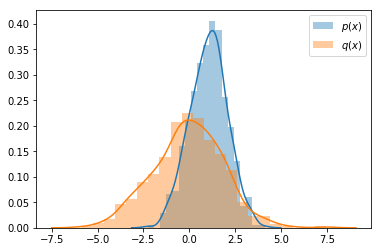

In [31]:
r = density_ratio(p, q)

sns.distplot(p.sample((500,)).numpy(), label='$p(x)$')
sns.distplot(q.sample((500,)).numpy(), label='$q(x)$')
# sns.distplot(r)
plt.legend()


<h2 id="analytical-form">Analytical Form</h2>

<p>For our running example, we picked $p(x)$ and $q(x)$ to be Gaussians so that
it is possible to integrate out $x$ and compute the KL divergence <em>analytically</em>.
When we introduce the approximate methods later, this will provide us a &ldquo;gold
standard&rdquo; to benchmark against.</p>

<p>In general, for Gaussian distributions</p>

<p>$$
p(x) = \mathcal{N}(x \mid \mu_p, \sigma_p^2),
\qquad
\text{and}
\qquad
q(x) = \mathcal{N}(x \mid \mu_q, \sigma_q^2),
$$
it is easy to verify that
$$
\mathrm{KL}[ p(x) || q(x) ]
= \log \sigma_q - \log \sigma_p - \frac{1}{2}
  \left [
    1 - \left ( \frac{\sigma_p^2 + (\mu_p - \mu_q)^2}{\sigma_q^2} \right )
  \right ].
$$</p>

<p>This is implemented below:</p>


In [35]:
def _kl_divergence_gaussians(p, q):
    r = p.loc - q.loc
    return (torch.log(q.scale) - torch.log(p.scale) -
            .5 * (1. - (p.scale**2 + r**2) / q.scale**2))

In [36]:
_kl_divergence_gaussians(p, q)

tensor(0.4431)

<p>Equivalently, we could also use <code>kl_divergence</code> from <em>TensorFlow
Probability&ndash;Distributions</em> (<code>tfp.distributions</code>), which implements the
analytical closed-form expression of the KL divergence between distributions
when such exists.</p>

In [37]:
dist.kl_divergence(p, q)

tensor(0.4431)

<h2 id="monte-carlo-estimation-prescribed-distributions">Monte Carlo Estimation &mdash; prescribed distributions</h2>

<p>For distributions where their KL divergence is not analytically tractable, we
may appeal to Monte Carlo (MC) estimation:</p>

<p>$$
\begin{align}
  \mathcal{D}_{\mathrm{KL}}[p(x) || q(x)]
  &amp; = \mathbb{E}_{p(x)} [ \log r^{*}(x) ] \newline
  &amp; \approx \frac{1}{M} \sum_{i=1}^{M} \log r^{*}(x_p^{(i)}),
  \quad x_p^{(i)} \sim p(x).
\end{align}
$$</p>

<p>Clearly, this requires the density ratio $r^{*}(x)$ and, in turn, the densities
$p(x)$ and $q(x)$ to be analytically tractable. Distributions for which the
density function can be readily evaluated are sometimes referred to as
<strong>prescribed distributions</strong>. As before, we <em>prescribed</em> Gaussians distributions
in our running example so the Monte Carlo estimate can be later compared against.
We approximate their KL divergence using $M = 5000$ Monte Carlo samples as
follows:</p>

<p>More generally, we can approximate any $f$-divergence with MC estimation:</p>

<p>$$
\begin{align}
  \mathcal{D}_f[p(x) || q(x)]
  &amp; = \mathbb{E}_{q(x)} [ f(r^{*}(x)) ] \newline
  &amp; \approx \frac{1}{M} \sum_{i=1}^{M} f(r^{*}(x_q^{(i)})),
  \quad x_q^{(i)} \sim q(x).
\end{align}
$$</p>

<p>This can be done using the  <code>monte_carlo_csiszar_f_divergence</code> function from
<em>TensorFlow Probability&ndash;Variational Inference</em> (<code>tfp.vi</code>).
One simply needs to specify the appropriate convex function $f$.
The convex function that instantiates the (forward) KL divergence is provided
in <code>tfp.vi</code> as <code>kl_forward</code>, alongside many other common $f$-divergences.</p>

<h2 id="density-ratio-estimation-implicit-distributions">Density Ratio Estimation &mdash; implicit distributions</h2>

<p>When either density $p(x)$ or $q(x)$ is unavailable, things become more tricky.
Which brings us to the topic of this post. Suppose we only have samples from
$p(x)$ and $q(x)$&mdash;these could be natural images, outputs from a neural
network with stochastic inputs, or in the case of our running example, i.i.d.
samples drawn from Gaussians, etc.
Distributions for which we are only able to observe their samples are known as
<strong>implicit distributions</strong>, since their samples <em>imply</em> some underlying true
density which we may not have direct access to.</p>

<p>Density ratio estimation is concerned with estimating the ratio of densities
$r^{*}(x) = p(x) / q(x)$ given access only to samples from $p(x)$ and $q(x)$.
Moreover, density ratio estimation usually encompass methods that achieve this
without resorting to direct <em>density estimation</em> of the individual densities
$p(x)$ or $q(x)$, since any error in the estimation of the denominator $q(x)$
is magnified exponentially.</p>

<p>Of the many density ratio estimation methods that now
flourish<sup class="footnote-ref" id="fnref:sugiyama2012density"><a href="#fn:sugiyama2012density">2</a></sup>, the classical approach of <em>probabilistic
classification</em> remains dominant, due in no small part to its simplicity.</p>

<h3 id="reducing-density-ratio-estimation-to-probabilistic-classification">Reducing Density Ratio Estimation to Probabilistic Classification</h3>

<p>We now demonstrate that density ratio estimation can be reduced to probabilistic
classification. We shall do this by highlighting the one-to-one correspondence
between the density ratio of $p(x)$ and $q(x)$ and the optimal probabilistic
classifier that discriminates between their samples.
Specifically, suppose we have a collection of samples from both $p(x)$ and $q(x)$,
where each sample is assigned a class label indicating which distribution it was
drawn from. Then, from an estimator of the class-membership probabilities, it is
straightforward to recover an estimator of the density ratio.</p>

<p>Suppose we have $N_p$ and $N_q$ samples drawn from $p(x)$ and $q(x)$,
respectively,</p>

<p>$$
x_p^{(1)}, \dotsc, x_p^{(N_p)} \sim p(x),
\qquad \text{and} \qquad
x_q^{(1)}, \dotsc, x_q^{(N_q)} \sim q(x).
$$</p>

<p>Then, we form the dataset ${ (x_n, y_n) }_{n=1}^N$, where $N = N_p + N_q$
and</p>

<p>$$
\begin{align}
  (x_1, \dotsc, x_N) &amp; = (x_p^{(1)}, \dotsc, x_p^{(N_p)},
                            x_q^{(1)}, \dotsc, x_q^{(N_q)}), \newline
  (y_1, \dotsc, y_N) &amp; = (\underbrace{1, \dotsc, 1}_{N_p},
                            \underbrace{0, \dotsc, 0}_{N_q}).
\end{align}
$$</p>

<p>In other words, we label samples drawn from $p(x)$ as 1 and those drawn from
$q(x)$ as 0. In code, this looks like:</p>

<p>This dataset is visualized below. The blue squares in the top row are samples
$x_p^{(i)} \sim p(x)$ with label 1; red squares in the bottom row are samples
$x_q^{(j)} \sim q(x)$ with label 0.</p>






<p>Now, by construction, we have</p>

<p>$$
p(x) = \mathcal{P}(x \mid y = 1),
\qquad
\text{and}
\qquad
q(x) = \mathcal{P}(x \mid y = 0).
$$</p>

<p>Using Baye&rsquo;s rule, we can write</p>

<p>$$
\mathcal{P}(x \mid y) =
\frac{\mathcal{P}(y \mid x) \mathcal{P}(x)}
     {\mathcal{P}(y)}.
$$</p>

<p>Hence, we can express the density ratio $r^{*}(x)$ as</p>

<p>$$
\begin{align}
  r^{*}(x) &amp; = \frac{p(x)}{q(x)}
       = \frac{\mathcal{P}(x \mid y = 1)}
              {\mathcal{P}(x \mid y = 0)} \newline
       &amp; = \left ( \frac{\mathcal{P}(y = 1 \mid x) \mathcal{P}(x)}
                        {\mathcal{P}(y = 1)} \right )
           \left ( \frac{\mathcal{P}(y = 0 \mid x) \mathcal{P}(x)}
                        {\mathcal{P}(y = 0)} \right ) ^ {-1} \newline
       &amp; = \frac{\mathcal{P}(y = 0)}{\mathcal{P}(y = 1)}
           \frac{\mathcal{P}(y = 1 \mid x)}
                {\mathcal{P}(y = 0 \mid x)}.
\end{align}
$$</p>

<p>Let us approximate the ratio of marginal densities by the ratio of sample sizes,</p>

<p>$$
\frac{\mathcal{P}(y = 0)}
     {\mathcal{P}(y = 1)}
\approx
\frac{N_q}{N_p + N_q}
\left ( \frac{N_p}{N_p + N_q} \right )^{-1}
= \frac{N_q}{N_p}.
$$</p>

<p>To avoid notational clutter, let us assume from now on that $N_q = N_p$.
We can then write $r^{*}(x)$ in terms of class-posterior probabilities,</p>

<p>$$
\begin{align}
  r^{*}(x) = \frac{\mathcal{P}(y = 1 \mid x)}
              {\mathcal{P}(y = 0 \mid x)}.
\end{align}
$$</p>

<h4 id="recovering-the-density-ratio-from-the-class-probability">Recovering the Density Ratio from the Class Probability</h4>

<p>This yields a one-to-one correspondence between the density ratio $r^{*}(x)$
and the class-posterior probability $\mathcal{P}(y = 1 \mid x)$.
Namely,</p>

<p>$$
\begin{align}
  r^{*}(x) = \frac{\mathcal{P}(y = 1 \mid x)}
              {\mathcal{P}(y = 0 \mid x)}
       &amp; = \frac{\mathcal{P}(y = 1 \mid x)}
                {1 - \mathcal{P}(y = 1 \mid x)} \newline
       &amp; = \exp
           \left [
             \log \frac{\mathcal{P}(y = 1 \mid x)}
                       {1 - \mathcal{P}(y = 1 \mid x)} \right ] \newline
       &amp; = \exp[ \sigma^{-1}(\mathcal{P}(y = 1 \mid x)) ],
\end{align}
$$</p>

<p>where $\sigma^{-1}$ is the <em>logit</em> function, or inverse sigmoid function, given
by $\sigma^{-1}(\rho) = \log \left ( \frac{\rho}{1-\rho} \right )$</p>

<h4 id="recovering-the-class-probability-from-the-density-ratio">Recovering the Class Probability from the Density Ratio</h4>

<p>By simultaneously manipulating both sides of this equation, we can also recover
the exact class-posterior probability as a function of the density ratio,</p>

<p>$$
\mathcal{P}(y=1 \mid x) = \sigma(\log r^{*}(x)) = \frac{p(x)}{p(x) + q(x)}.
$$</p>

<p>This is implemented below:</p>

<p>In the figure below, The class-posterior probability $\mathcal{P}(y=1 \mid x)$
is plotted against the dataset visualized earlier.</p>




<figure>

<img src="optimal_classifier.svg" alt="Optimal classifier---class-posterior probabilities." />



<figcaption data-pre="Figure " data-post=":" >
  
  <p>
    Optimal classifier&mdash;class-posterior probabilities.
    
    
    
  </p> 
</figcaption>

</figure>

<!-- <div class="alert alert-note">
  <div>
    <p>If there is just one thing you take away from this post, let it be this:</p>

<p>$$
r^{*}(x) = \exp[ \sigma^{-1}(\mathcal{P}(y = 1 \mid x)) ],
$$</p>

  </div>
</div>

 -->

<h3 id="probabilistic-classification-with-logistic-regression">Probabilistic Classification with Logistic Regression</h3>

<p>The class-posterior probability $\mathcal{P}(y = 1 \mid x)$ can be approximated
using a parameterized function $D_{\theta}(x)$ with parameters $\theta$. This
functions takes as input samples from $p(x)$ and $q(x)$ and outputs a <em>score</em>,
or probability, in the range $[0, 1]$ that it was drawn from $p(x)$.
Hence, we refer to $D_{\theta}(x)$ as the probabilistic classifier.</p>

<p>From before, it is clear to see how an estimator of the density ratio
$r_{\theta}(x)$ might be constructed as a function of probabilistic classifier
$D_{\theta}(x)$. Namely,</p>

<p>$$
\begin{align}
  r_{\theta}(x) &amp; = \exp[ \sigma^{-1}(D_{\theta}(x)) ] \newline
  &amp; \approx \exp[ \sigma^{-1}(\mathcal{P}(y = 1 \mid x)) ] = r^{*}(x),
\end{align}
$$
and <em>vice versa</em>,
$$
\begin{align}
  D_{\theta}(x) &amp; = \sigma(\log r_{\theta}(x)) \newline
  &amp; \approx \sigma(\log r^{*}(x)) = \mathcal{P}(y = 1 \mid x).
\end{align}
$$</p>

<p>Instead of $D_{\theta}(x)$, we usually specify the parameterized function
$\log r_{\theta}(x)$. This is also referred to as the <em>log-odds</em>, or <em>logits</em>,
since it is equivalent to the unnormalized output of the classifier before being
fed through the logistic sigmoid function.</p>

<p>We define a small fully-connected neural network with two hidden layers and ReLU
activations:</p>

<pre><code class="language-python">log_ratio = Sequential([
    Dense(16, input_dim=1, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1),
])
</code></pre>

<p>This simple architecture is visualized in the diagram below:</p>




<figure>

<img src="log_ratio_architecture.svg" alt="Log Density Ratio Architecture." />



<figcaption data-pre="Figure " data-post=":" >
  
  <p>
    Log Density Ratio Architecture.
    
    
    
  </p> 
</figcaption>

</figure>

<p>We learn the optimal class probability estimator by optimizing it with respect
to a <em>proper scoring rule</em><sup class="footnote-ref" id="fnref:gneiting2007strictly"><a href="#fn:gneiting2007strictly">3</a></sup> that yields well-calibrated probabilistic predictions, such as the <em>binary cross-entropy loss</em>,</p>

<p>$$
\begin{align}
  \mathcal{L}(\theta) &amp; :=
  - \mathbb{E}_{p(x)} [ \log D_{\theta} (x) ]
  - \mathbb{E}_{q(x)} [ \log(1-D_{\theta} (x)) ] \newline
  &amp; =
  - \mathbb{E}_{p(x)} [ \log \sigma ( \log r_{\theta} (x) ) ]
  - \mathbb{E}_{q(x)} [ \log(1 - \sigma ( \log r_{\theta} (x) )) ].
\end{align}
$$</p>

<p>An implementation optimized for numerical stability is given below:</p>

<pre><code class="language-python">def _binary_crossentropy(log_ratio_p, log_ratio_q):

    loss_p = tf.nn.sigmoid_cross_entropy_with_logits(
        logits=log_ratio_p,
        labels=tf.ones_like(log_ratio_p)
    )

    loss_q = tf.nn.sigmoid_cross_entropy_with_logits(
        logits=log_ratio_q,
        labels=tf.zeros_like(log_ratio_q)
    )

    return tf.reduce_mean(loss_p + loss_q)
</code></pre>

<p>Now we can build a <a href="https://keras.io/getting-started/functional-api-guide/#multi-input-and-multi-output-models" target="_blank">multi-input/multi-output model</a>, where the <a href="http://louistiao.me/notes/keras-constant-input-layers-with-fixed-source-of-stochasticity/" target="_blank">inputs
are fixed with stochastic tensors</a>&mdash;samples from
$p(x)$ and $q(x)$, respectively.</p>

<pre><code class="language-python">&gt;&gt;&gt; x_p = Input(tensor=p_samples)
&gt;&gt;&gt; x_q = Input(tensor=q_samples)
&gt;&gt;&gt; log_ratio_p = log_ratio(x_p)
&gt;&gt;&gt; log_ratio_q = log_ratio(x_q)
</code></pre>

<p>The model can now be compiled and finalized. Since we&rsquo;re using a custom loss
that take the two sets of log-ratios as input, we specify <code>loss=None</code> and
define it instead through the <code>add_loss</code> method.</p>

<pre><code class="language-python">&gt;&gt;&gt; m = Model(inputs=[x_p, x_q], outputs=[log_ratio_p, log_ratio_q])
&gt;&gt;&gt; m.add_loss(_binary_crossentropy(log_ratio_p, log_ratio_q))
&gt;&gt;&gt; m.compile(optimizer='rmsprop', loss=None)
</code></pre>

<p>As a sanity-check, the loss evaluated on a random batch can be obtained like so:</p>

<pre><code class="language-python">&gt;&gt;&gt; m.evaluate(x=None, steps=1)
1.3765026330947876
</code></pre>

<p>We can now fit our estimator, recording the loss at the end of each epoch:</p>

<pre><code class="language-python">&gt;&gt;&gt; hist = m.fit(x=None, y=None, steps_per_epoch=1, epochs=500)
</code></pre>

<p>The following animation shows how the predictions for the probabilistic
classifier, density ratio, log density ratio, evolve after every epoch:</p>

<video controls autoplay src="https://giant.gfycat.com/FrighteningThunderousFlicker.webm"></video>

<p>It is overlaid on top of their exact, analytical counterparts, which are only
available since we prescribed them to be Gaussian distribution.
For implicit distributions, these won&rsquo;t be accessible at all.</p>

<p>Below is the final plot of how the binary cross-entropy loss converges:</p>




<figure>

<img src="binary_crossentropy.svg" alt="Binary Cross-entropy Loss." />



<figcaption data-pre="Figure " data-post=":" >
  
  <p>
    Binary Cross-entropy Loss.
    
    
    
  </p> 
</figcaption>

</figure>

<p>Below is a plot of the probabilistic classifier $D_{\theta}(x)$ (<em>dotted green</em>),
plotted against the optimal classifier, which is the class-posterior probability
$\mathcal{P}(y=1 \mid x) = \frac{p(x)}{p(x) + q(x)}$ (<em>solid blue</em>):</p>




<figure>

<img src="class_probability_estimation.svg" alt="Class Probability Estimator." />



<figcaption data-pre="Figure " data-post=":" >
  
  <p>
    Class Probability Estimator.
    
    
    
  </p> 
</figcaption>

</figure>

<p>Below is a plot of the density ratio estimator $r_{\theta}(x)$
(<em>dotted green</em>), plotted against the exact density ratio function
$r^{*}(x) = \frac{p(x)}{q(x)}$ (<em>solid blue</em>):</p>




<figure>

<img src="density_ratio_estimation.svg" alt="Density Ratio Estimator." />



<figcaption data-pre="Figure " data-post=":" >
  
  <p>
    Density Ratio Estimator.
    
    
    
  </p> 
</figcaption>

</figure>

<p>And finally, the previous plot in logarithmic scale:</p>




<figure>

<img src="log_density_ratio_estimation.svg" alt="Log Density Ratio Estimator." />



<figcaption data-pre="Figure " data-post=":" >
  
  <p>
    Log Density Ratio Estimator.
    
    
    
  </p> 
</figcaption>

</figure>

<p>While it may appear that we are simply performing regression on the latent
function $r^{*}(x)$ (which is not wrong&mdash;we are), it is important to emphasize that
we do this without ever having observed values of $r^{*}(x)$.
Instead, we only ever observed samples from $p(x)$ and $q(x)$
This has profound implications and potential for a great number of applications
that we shall explore later on.</p>

<h3 id="back-to-monte-carlo-estimation">Back to Monte Carlo estimation</h3>

<p>Having an obtained an estimate of the log density ratio, it is now feasible to
perform Monte Carlo estimation:</p>

<p>$$
\begin{align}
  \mathcal{D}_{\mathrm{KL}}[p(x) || q(x)]
  &amp; = \mathbb{E}_{p(x)} [ \log r^{*}(x) ] \newline
  &amp; \approx \frac{1}{M} \sum_{i=1}^{M} \log r^{*}(x_p^{(i)}),
  \quad x_p^{(i)} \sim p(x) \newline
  &amp; \approx \frac{1}{M} \sum_{i=1}^{M} \log r_{\theta}(x_p^{(i)}),
  \quad x_p^{(i)} \sim p(x).
\end{align}
$$</p>

<pre><code class="language-python">&gt;&gt;&gt; tf.squeeze(tfp.monte_carlo.expectation(f=log_ratio, samples=p_samples)).eval()
0.4570999
</code></pre>

<p>In other words, we draw MC samples from $p(x)$ as before. But instead of taking
the mean of the function $\log r^{*}(x)$ evaluated on these samples (which is
unavailable for implicit distributions), we do so on a proxy function
$\log r_{\theta}(x)$ that is estimated through probabilistic classification as
described above.</p>

<h2 id="learning-in-implicit-generative-models">Learning in Implicit Generative Models</h2>

<p>Now let&rsquo;s take a look at where these ideas are being used in practice.
Consider a collection of natural images, such as the MNIST handwritten
digits shown below, which are assumed to be samples drawn from some implicit
distribution $q(\mathbf{x})$:</p>




<figure>

<img src="MnistExamples.png" alt="MNIST hand-written digits." />



<figcaption data-pre="Figure " data-post=":" >
  
  <p>
    MNIST hand-written digits.
    
    
    
  </p> 
</figcaption>

</figure>

<p>Directly estimating the density of $q(\mathbf{x})$ may not always be feasible&mdash;in
some cases, it may not even exist.
Instead, consider defining a parametric function $G_{\phi}: \mathbf{z} \mapsto
\mathbf{x}$ with parameters $\phi$, that takes as input $\mathbf{z}$ drawn from
some fixed distribution $p(\mathbf{z})$.
The outputs $\mathbf{x}$ of this generative process are assumed to be samples
following some implicit distribution $p_{\phi}(\mathbf{x})$. In other words,
we can write</p>

<p>$$
\mathbf{x} \sim p_{\phi}(\mathbf{x}) \quad
\Leftrightarrow \quad
\mathbf{x} = G_{\phi}(\mathbf{z}),
\quad \mathbf{z} \sim p(\mathbf{z}).
$$</p>

<p>By optimizing parameters $\phi$, we can make $p_{\phi}(\mathbf{x})$ close to
the real data distribution $q(\mathbf{x})$. This is a compelling alternative to
density estimation since there are many situations where being able to generate
samples is more important than being able to calculate the numerical value of
the density. Some examples of these include <em>image super-resolution</em> and
<em>semantic segmentation</em>.</p>

<p>One approach might be to introduce a classifier $D_{\theta}$ that discriminates
between real and synthetic samples.
Then we optimize $G_{\phi}$ to synthesize samples that are indistinguishable,
to classifier $D_{\theta}$, from the real samples. This can be achieved by
simultaneously optimizing the binary cross-entropy loss, resulting in the
saddle-point objective,</p>

<p>$$
\begin{align}
  &amp; \min_{\phi} \max_{\theta}
  \mathbb{E}_{q(\mathbf{x})} [ \log D_{\theta} (\mathbf{x}) ] +
  \mathbb{E}_{p_{\phi}(\mathbf{x})} [ \log(1-D_{\theta} (\mathbf{x})) ] \newline
  =
  &amp; \min_{\phi} \max_{\theta}
  \mathbb{E}_{q(\mathbf{x})} [ \log D_{\theta} (\mathbf{x}) ] +
  \mathbb{E}_{p(\mathbf{z})} [ \log(1-D_{\theta} (G_{\phi}(\mathbf{z}))) ].
\end{align}
$$</p>

<p>This is, of course, none other than the groundbreaking <em>generative adversarial
network (GAN)</em><sup class="footnote-ref" id="fnref:goodfellow2014generative"><a href="#fn:goodfellow2014generative">4</a></sup>.
You can read more about the density ratio estimation perspective of GANs in
the paper by Uehara et al. 2016<sup class="footnote-ref" id="fnref:uehara2016generative"><a href="#fn:uehara2016generative">5</a></sup>. For an even more general and complete treatment of learning in implicit models, I recommend the paper
from Mohamed and Lakshminarayanan, 2016<sup class="footnote-ref" id="fnref:mohamed2016learning"><a href="#fn:mohamed2016learning">6</a></sup>, which partially inspired this post.</p>

<p>For the remainder of this section, I want to highlight a variant of this
approach that specifically aims to minimize the KL divergence w.r.t. parameters
$\phi$,</p>

<p>$$
\min_{\phi} \mathcal{D}_{\mathrm{KL}}[p_{\phi}(\mathbf{x}) || q(\mathbf{x})].
$$</p>

<p>To overcome the fact that the densities of both $p_{\phi}(\mathbf{x})$ and
$q(\mathbf{x})$ are unknown, we can readily adopt the density ratio estimation
approach outlined in this post.
Namely, by maximizing the following objective,</p>

<p>$$
\begin{align}
  &amp; \max_{\theta}
  \mathbb{E}_{q(\mathbf{x})} [ \log D_{\theta} (\mathbf{x}) ] +
  \mathbb{E}_{p(\mathbf{z})} [ \log(1-D_{\theta} (G_{\phi}(\mathbf{z}))) ] \newline
  = &amp; \max_{\theta}
  \mathbb{E}_{q(\mathbf{x})} [ \log \sigma ( \log r_{\theta} (\mathbf{x}) ) ] +
  \mathbb{E}_{p(\mathbf{z})} [ \log(1 - \sigma ( \log r_{\theta} (G_{\phi}(\mathbf{z})) )) ],
\end{align}
$$</p>

<p>which attains its maximum at</p>

<p>$$
r_{\theta}(\mathbf{x}) = \frac{q(\mathbf{x})}{p_{\phi}(\mathbf{x})}.
$$</p>

<p>Concurrently, we also minimize the current best estimate of the KL divergence,</p>

<p>$$
\begin{align}
\min_{\phi} \mathcal{D}_{\mathrm{KL}}[p_{\phi}(\mathbf{x}) || q(\mathbf{x})]
&amp; =
\min_{\phi} \mathbb{E}_{p_{\phi}(\mathbf{x})} \left [ \log \frac{p_{\phi}(\mathbf{x})}{q(\mathbf{x})} \right ] \newline
&amp; \approx
\min_{\phi} \mathbb{E}_{p_{\phi}(\mathbf{x})} [ - \log r_{\theta}(\mathbf{x}) ] \newline
&amp; =
\min_{\phi} \mathbb{E}_{p(\mathbf{z})} [ - \log r_{\theta}(G_{\phi}(\mathbf{z})) ].
\end{align}
$$</p>

<p>In addition to being more stable than the vanilla GAN approach (alleviates
saturating gradients), this is especially important in contexts where there is
a specific need to minimize the KL divergence, such as in <em>variational inference
(VI)</em>.</p>

<p>This was first used in <em>AffGAN</em> by Sønderby et al. 2016<sup class="footnote-ref" id="fnref:sonderby2016amortised"><a href="#fn:sonderby2016amortised">7</a></sup>,
and has since been incorporated in many papers that deal with implicit
distributions in variational inference, such as
(Mescheder et al. 2017<sup class="footnote-ref" id="fnref:mescheder2017adversarial"><a href="#fn:mescheder2017adversarial">8</a></sup>,
Huszar 2017<sup class="footnote-ref" id="fnref:huszar2017variational"><a href="#fn:huszar2017variational">9</a></sup>,
Tran et al. 2017<sup class="footnote-ref" id="fnref:tran2017hierarchical"><a href="#fn:tran2017hierarchical">10</a></sup>,
Pu et al. 2017<sup class="footnote-ref" id="fnref:pu2017adversarial"><a href="#fn:pu2017adversarial">11</a></sup>,
Chen et al. 2018<sup class="footnote-ref" id="fnref:chen2018symmetric"><a href="#fn:chen2018symmetric">12</a></sup>,
Tiao et al. 2018<sup class="footnote-ref" id="fnref:tiao2018cycle"><a href="#fn:tiao2018cycle">13</a></sup>), and many others.</p>

<h2 id="bound-on-the-jensen-shannon-divergence">Bound on the Jensen-Shannon Divergence</h2>

<p>Before we wrap things up, let us take another look at the plot of the
binary-cross entropy loss recorded at the end of each epoch.
We see that it converges quickly to some value.
It is natural to wonder: what is the significance, if any, of this value?</p>




<figure>

<img src="binary_crossentropy_vs_jensen_shannon.svg" alt="Binary cross-entropy loss converges to Jensen Shannon divergence (up to constants)." />



<figcaption data-pre="Figure " data-post=":" >
  
  <p>
    Binary cross-entropy loss converges to Jensen Shannon divergence (up to constants).
    
    
    
  </p> 
</figcaption>

</figure>

<p>It is in fact the (negative) Jensen-Shannon (JS) divergence, up to constants,</p>

<p>$$
- 2 \cdot \mathcal{D}_{\mathrm{JS}}[p(x) || q(x)] + \log 4.
$$</p>

<p>Recall the Jensen-Shannon divergence is defined as</p>

<p>$$
\mathcal{D}_{\mathrm{JS}}[p(x) || q(x)]
= \frac{1}{2} \mathcal{D}_{\mathrm{KL}}[p(x) || m(x)] +
  \frac{1}{2} \mathcal{D}_{\mathrm{KL}}[q(x) || m(x)],
$$</p>

<p>where $m$ is the mixture density</p>

<p>$$
m(x) = \frac{p(x) + q(x)}{2}.
$$</p>

<p>With our running example, this cannot be evaluated exactly since the KL
divergence between a Gaussian and a mixture of Gaussians is analytically
tractable. However, like the KL, we can still estimate their JS divergence with
Monte Carlo estimation<sup class="footnote-ref" id="fnref:2"><a href="#fn:2">14</a></sup>:</p>

<pre><code class="language-python">&gt;&gt;&gt; js = - tfp.vi.monte_carlo_csiszar_f_divergence(f=tfp.vi.jensen_shannon,
...                                                p_log_prob=p.log_prob,
...                                                q=q, num_draws=5000)
</code></pre>



<p>This value is shown in the horizontal black line in the plot above. Along the
right margin, we also plot the a histogram of the binary cross-entropy loss
values over epochs. We can see that this value indeed coincides with the mode of
this histogram.</p>

<p>It is straightforward to show that we have the upper bound</p>

<p>$$
\inf_{\theta} \mathcal{L}(\theta)
\geq
- 2 \cdot \mathcal{D}_{\mathrm{JS}}[p(x) || q(x)] + \log 4.
$$</p>

<p>Firstly, we have</p>

<p>$$
\begin{align}
  \sup_{\theta} &amp;
  \mathbb{E}_{p(x)} [ \log D_{\theta} (x) ] +
  \mathbb{E}_{q(x)} [ \log(1-D_{\theta} (x)) ] \newline
  &amp; =
  \mathbb{E}_{p(x)} [ \log \mathcal{P}(y=1 \mid x) ] +
  \mathbb{E}_{q(x)} [ \log \mathcal{P}(y=0 \mid x) ] \newline
  &amp; =
  \mathbb{E}_{p(x)} \left [ \log \frac{p(x)}{p(x) + q(x)} \right ] +
  \mathbb{E}_{q(x)} \left [ \log \frac{q(x)}{p(x) + q(x)} \right ] \newline
  &amp; =
  \mathbb{E}_{p(x)} \left [ \log \frac{1}{2} \frac{p(x)}{m(x)} \right ] +
  \mathbb{E}_{q(x)} \left [ \log \frac{1}{2} \frac{q(x)}{m(x)} \right ] \newline
  &amp; =
  \mathbb{E}_{p(x)} \left [ \log \frac{p(x)}{m(x)} \right ] +
  \mathbb{E}_{q(x)} \left [ \log \frac{q(x)}{m(x)} \right ] - 2 \log 2 \newline
  &amp; = 2 \cdot \mathcal{D}_{\mathrm{JS}}[p(x) || q(x)] - \log 4.
\end{align}
$$</p>

<p>Therefore,</p>

<p>$$
2 \cdot \mathcal{D}_{\mathrm{JS}}[p(x) || q(x)] - \log 4
\geq
\sup_{\theta}
\mathbb{E}_{p(x)} [ \log D_{\theta} (x) ] +
\mathbb{E}_{q(x)} [ \log(1-D_{\theta} (x)) ].
$$</p>

<p>Negating both sides, we get</p>

<p>$$
\begin{align}
  - 2 \cdot \mathcal{D}_{\mathrm{JS}}[p(x) || q(x)] + \log 4
  \leq &amp;
  - \sup_{\theta}
  \mathbb{E}_{p(x)} [ \log D_{\theta} (x) ] +
  \mathbb{E}_{q(x)} [ \log(1-D_{\theta} (x)) ] \newline
  = &amp; \inf_{\theta}
  - \mathbb{E}_{p(x)} [ \log D_{\theta} (x) ]
  - \mathbb{E}_{q(x)} [ \log(1-D_{\theta} (x)) ] \newline
  = &amp; \inf_{\theta} \mathcal{L}(\theta),
\end{align}
$$</p>

<p>as required.</p>

<p>In short, this tells us that the binary cross-entropy loss is <em>itself</em> an
approximation (up to constants) to the Jensen-Shannon divergence.
This begs the question: is it possible to construct a more general loss that bounds any given $f$-divergence?</p>

<h2 id="teaser-lower-bound-on-any-f-divergence">Teaser: Lower Bound on any $f$-divergence</h2>

<p>Using convex analysis, one can actually show that for any $f$-divergence, we
have the lower bound<sup class="footnote-ref" id="fnref:nguyen2010estimating"><a href="#fn:nguyen2010estimating">15</a></sup></p>

<p>$$
\mathcal{D}_f[p(x) || q(x)]
\geq
\sup_{\theta}
\mathbb{E}_{p(x)} [ f&rsquo;(r_{\theta}(x)) ] -
\mathbb{E}_{q(x)} [ f^{\star}(f&rsquo;(r_{\theta}(x))) ],
$$</p>

<p>with equality exactly when $r_{\theta}(x) = r^{*}(x)$.
Importantly, this lower bound can be computed without requiring the densities of
$p(x)$ or $q(x)$&mdash;only their samples are needed.</p>

<p>In the special case of $f(u) = u \log u - (u + 1) \log (u + 1)$, we recover the
binary cross-entropy loss and the previous result, as expected,</p>

<p>$$
\begin{align}
  \mathcal{D}_f[p(x) || q(x)]
  &amp; = 2 \cdot \mathcal{D}_{\mathrm{JS}}[p(x) || q(x)] - \log 4 \newline
  &amp; \geq \sup_{\theta}
  \mathbb{E}_{p(x)} [ \log \sigma ( \log r_{\theta} (x) ) ] +
  \mathbb{E}_{q(x)} [ \log(1 - \sigma ( \log r_{\theta} (x) )) ] \newline
  &amp; = \sup_{\theta}
  \mathbb{E}_{p(x)} [ \log D_{\theta} (x) ] +
  \mathbb{E}_{q(x)} [ \log(1-D_{\theta} (x)) ].
\end{align}
$$</p>

<p>Alternately, in the special case of $f(u) = u \log u$, we get</p>

<p>$$
\begin{align}
  \mathcal{D}_f[p(x) || q(x)]
  &amp; = \mathcal{D}_{\mathrm{KL}}[p(x) || q(x)] \newline
  &amp; \geq \sup_{\theta}
  \mathbb{E}_{p(x)} [ \log r_{\theta} (x) ] -
  \mathbb{E}_{q(x)} [ r_{\theta} (x) - 1 ].
\end{align}
$$</p>

<p>This gives us <em>yet</em> another way to estimate the KL divergence between
implicit distributions, in the form of a direct lower bound on the KL divergence
itself.
As it turns out, this lower bound is closely-related to the objective of the
<em>KL Importance Estimation Procedure (KLIEP)</em><sup class="footnote-ref" id="fnref:sugiyama2008direct"><a href="#fn:sugiyama2008direct">16</a></sup>, and will be
the topic of our next post in this series.</p>

<h1 id="summary">Summary</h1>

<p>This post covered how to evaluate the KL divergence, or any $f$-divergence,
between implicit distributions&mdash;distributions which we can only sample from.
First, we underscored the crucial role of the density ratio in the estimation of
$f$-divergences.
Next, we showed the correspondence between the density ratio and the optimal
classifier.
By exploiting this link, we demonstrated how one can use a trained probabilistic classifier to construct a proxy for the exact density ratio, and use this to
enable estimation of any $f$-divergence.
Finally, we provided some context on where this method is used, touching upon
some recent advances in implicit generative models and variational inference.</p>
